<a href="https://colab.research.google.com/github/jeannie068/ML_Workpiece-Recognition/blob/main/ML_Workpiece%20-Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!gdown --id '1qCHfycy91EyUFzilBvxu8hYVYp0l6jCh' --output /tmp/MidTerm_Dataset.zip

/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1qCHfycy91EyUFzilBvxu8hYVYp0l6jCh
To: /tmp/MidTerm_Dataset.zip
100% 50.4M/50.4M [00:00<00:00, 117MB/s]


In [ ]:
import os
import zipfile
local_zip = '/tmp/MidTerm_Dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [ ]:
%cd ..
%cd /tmp/MidTerm_Dataset

/
/tmp/MidTerm_Dataset


In [ ]:
import numpy as np
import random
import os
import keras
from PIL import Image #PIL 提供處理image的模組
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle
from sklearn import datasets, preprocessing
from sklearn.model_selection import train_test_split

import cv2
import tensorflow as tf
from tqdm import tqdm
from keras.models import Sequential #建立最簡單的線性模型 (Sequentia1），就是一層層往下執行，沒有分叉 (If)
from keras.optimizers import SGD, Adam
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D #CNN 的捲積層和池化層
from keras.utils import np_utils #用來後續將 Label 標籤轉為 one-hot-encoding
from matplotlib import pyplot as plt #用來繪製優化過程曲線的套件


In [ ]:
#'定義子資料夾名稱&對應的數字'
class_names = ['bolt', 'locatingpin', 'nut', 'washer']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (224, 224)
#%%
def load_data():
    datasets = ['Train', 'Test']#資料夾
    output = []

    # Iterate through training and test sets
    for dataset in datasets:

        images = []
        labels = []

        print("Loading {}".format(dataset))

        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]

            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):

                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)

                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                #cv讀照片，顏色莫認為BGR，需轉為RGB，錯誤表示黑白或已轉
                image = cv2.resize(image, IMAGE_SIZE)

                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)

        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')

        output.append((images, labels))

    return output
#%%
(data_train_X, data_train_Y), (data_test_X, data_test_Y) = load_data()
#%%

Loading Train


100%|██████████| 1523/1523 [00:00<00:00, 1753.76it/s]


Loading Test


100%|██████████| 381/381 [00:00<00:00, 2020.82it/s]


In [ ]:
#%%
data_train_X, data_val_X, data_train_Y, data_val_Y = train_test_split(data_train_X, data_train_Y, test_size = 0.2, random_state = 42)
'隨機性'
data_train_X, data_train_Y = shuffle(data_train_X, data_train_Y, random_state=25)
'標準化'
data_train_X = data_train_X / 255.0
data_test_X = data_test_X / 255.0
#%%
'建模'
input_shape = (224, 224, 3)

model = Sequential([
    Conv2D(64, (3, 3), input_shape=input_shape, padding='same',
           activation='relu', strides=2),      #建立卷積層，filter=32
    MaxPooling2D(pool_size=(2, 2), strides=2), #建立池化層，池化大小=2×2，取最大值
    Dropout(0.2),                              # Dropout層隨機断開輸入神經元，用於防止過度擬合，断開比例：0.25

    Conv2D(128, (3, 3), input_shape=input_shape, padding='same',
           activation='relu', strides=2),      #建立卷積層，filter=32

    MaxPooling2D(pool_size=(2, 2), strides=2), #建立池化層，池化大小=2×2，取最大值
    Dropout(0.2),                              # Dropout層隨機断開輸入神經元，用於防止過度擬合，断開比例：0.2

    Flatten(),                                 # Flatten層把多維的輸入一維化，常用在從卷積層到全連接層的過渡。
    Dense(256, activation="relu"),
    Dropout(0.5),                              # Dropout層隨機断開輸入神經元，用於防止過度擬合，断開比例：0.
    Dense(4, activation='softmax')             #輸出層，分類用softmax
])


'''
model.compile(optimizer = 'adam', #SGD(lr=0.1)
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])
              '''
#%%

"\nmodel.compile(optimizer = 'adam', #SGD(lr=0.1)\n              loss = 'sparse_categorical_crossentropy',\n              metrics=['accuracy'])\n              "

In [ ]:
model.summary() # 查看模型架構

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 56, 56, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 56, 56, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 128)      0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 14, 14, 128)       0

In [ ]:
#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(optimizer = 'adam', #SGD(lr=0.1)
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])
'''
history = model.fit(data_train_X, data_train_Y,
                    #validation_data=(test_images, test_labels),
                    #verbose=2,callbacks=[earlyStop],
                    batch_size=128, epochs=10)
                    '''
history = model.fit(data_train_X, data_train_Y, validation_split=0.2, epochs=35, batch_size=128, verbose=2)

Epoch 1/50
31/31 - 18s - loss: 2.0211 - accuracy: 0.2537 - val_loss: 1.3804 - val_accuracy: 0.4021 - 18s/epoch - 580ms/step
Epoch 2/50
31/31 - 4s - loss: 1.3450 - accuracy: 0.3368 - val_loss: 1.2484 - val_accuracy: 0.6154 - 4s/epoch - 122ms/step
Epoch 3/50
31/31 - 4s - loss: 1.0899 - accuracy: 0.5416 - val_loss: 0.8083 - val_accuracy: 0.7251 - 4s/epoch - 122ms/step
Epoch 4/50
31/31 - 3s - loss: 0.7679 - accuracy: 0.6921 - val_loss: 0.5768 - val_accuracy: 0.7754 - 3s/epoch - 108ms/step
Epoch 5/50
31/31 - 4s - loss: 0.6311 - accuracy: 0.7573 - val_loss: 0.5416 - val_accuracy: 0.7908 - 4s/epoch - 128ms/step
Epoch 6/50
31/31 - 4s - loss: 0.5726 - accuracy: 0.7840 - val_loss: 0.5125 - val_accuracy: 0.8113 - 4s/epoch - 117ms/step
Epoch 7/50
31/31 - 4s - loss: 0.5478 - accuracy: 0.7948 - val_loss: 0.4658 - val_accuracy: 0.8164 - 4s/epoch - 115ms/step
Epoch 8/50
31/31 - 4s - loss: 0.5027 - accuracy: 0.8214 - val_loss: 0.4492 - val_accuracy: 0.8328 - 4s/epoch - 116ms/step
Epoch 9/50
31/31 - 4s 

Test loss: 0.14559055864810944
Test accuracy: 0.9593175649642944


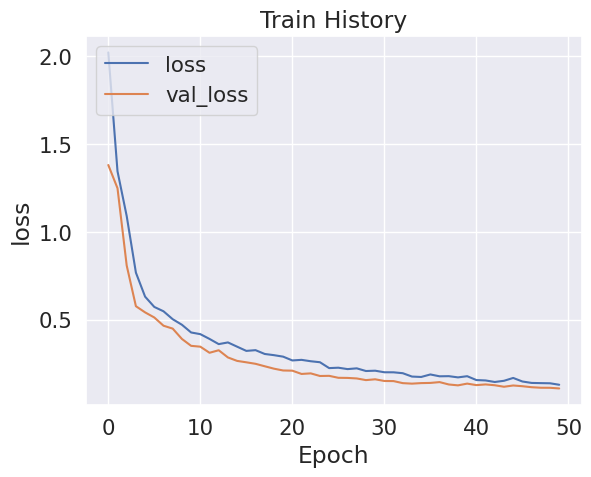

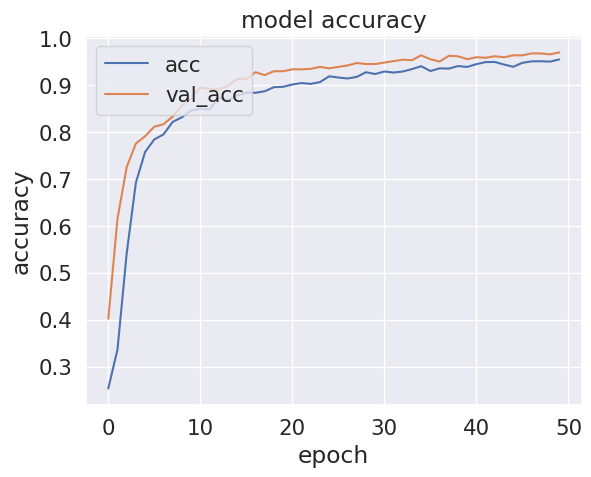

In [ ]:
score = model.evaluate (data_test_X, data_test_Y, verbose=0)
print ( 'Test loss:', score[0])
print ( 'Test accuracy:', score[1])

#plt.subplot(2, 1, 1)
plt.plot (history.history['loss'])
plt.plot (history.history['val_loss'])
plt.title ( 'Train History')
plt.ylabel ( 'loss' )
plt.xlabel ( 'Epoch')
plt.legend ( ['loss', 'val_loss'], loc='upper left' )
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['acc', 'val_acc'], loc='upper left') #plt.show()

plt.show()